# Imports

## TODO

1) Import word-vocab 
2) Get the new datasets
3) Try training
4) Try Testing 
5) Start paper 

## Packages

In [2]:
import torch
import numpy as np
import os
import json
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
import matplotlib.pyplot as plt
import clip
import sys
sys.path.append('/home/guest/Documents/Siraj TM/RSCaMa')
from model.model_decoder import DecoderTransformer
import torchvision.transforms.functional as TF
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.layers import drop_path, trunc_normal_
from PIL import Image


/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Functions

In [3]:
def load_json(path):
    with open(path) as f:
        file = json.load(f)
    f.close()
    return file
def save_json(file,path):
    with open(path,'w') as f:
        json.dump(file,f)
    f.close()
    print("Saved Successfully")
def rem_print(word):
    t_word = word
    for _ in range(100 - len(t_word)):
        word = word + ' '
    print(word,end='\r')

## Data

In [4]:
word_vocab = load_json('assets/vocab.json')

# Model

## Architecture imports

### Bottleneck

In [5]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


### AttentionPool2d

In [6]:
class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.spacial_dim = spacial_dim

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC

        cls_pos = self.positional_embedding[0:1, :]
        spatial_pos = F.interpolate(self.positional_embedding[1:,].reshape(1, self.spacial_dim, self.spacial_dim, self.embed_dim).permute(0, 3, 1, 2), size=(H, W), mode='bilinear')
        spatial_pos = spatial_pos.reshape(self.embed_dim, H*W).permute(1, 0)
        positional_embedding = torch.cat([cls_pos, spatial_pos], dim=0)

        x = x + positional_embedding[:, None, :]
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        x = x.permute(1, 2, 0)
        global_feat = x[:, :, 0]
        feature_map = x[:, :, 1:].reshape(B, -1, H, W)
        return global_feat, feature_map


### CLIPResNetWithAttention

In [7]:
class CLIPResNetWithAttention(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim=1024, input_resolution=224, width=64, pretrained=None, **kwargs):
        super().__init__()
        self.pretrained = pretrained
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, 32, output_dim)
        # self.init_weights()

    def init_weights(self, pretrained=None):
        pretrained = pretrained or self.pretrained
        if isinstance(pretrained, str):
            checkpoint = torch.jit.load(pretrained, map_location=device).float().state_dict()

            state_dict = {}

            for k in checkpoint.keys():
                if k.startswith('visual.'):
                    new_k = k.replace('visual.', '')
                    state_dict[new_k] = checkpoint[k]

                    if 'positional_embedding' in new_k:
                        if self.attnpool.positional_embedding.shape != state_dict[new_k].shape:
                            print(f'Resize the pos_embed shape from {state_dict[new_k].shape} to {self.attnpool.positional_embedding.shape}')
                            cls_pos = state_dict[new_k][0:1, :]
                            H = W = self.input_resolution // 32
                            old_h = int(math.sqrt(state_dict[new_k][1:,].shape[0]))
                            spatial_pos = F.interpolate(state_dict[new_k][1:,].reshape(1, old_h, old_h, cls_pos.shape[1]).permute(0, 3, 1, 2), size=(H, W), mode='bilinear')
                            spatial_pos = spatial_pos.reshape(cls_pos.shape[1], H*W).permute(1, 0)
                            positional_embedding = torch.cat([cls_pos, spatial_pos], dim=0)
                            state_dict[new_k] = positional_embedding
                            assert self.attnpool.positional_embedding.shape == state_dict[new_k].shape

            u, w = self.load_state_dict(state_dict, False)
            print(u, w, 'are misaligned params in CLIPResNet')

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)

        outs = []
        x = self.layer1(x)
        outs.append(x)
        x = self.layer2(x)
        outs.append(x)
        x = self.layer3(x)
        outs.append(x)
        x = self.layer4(x)
        outs.append(x)

        x_global, x_local = self.attnpool(x)
        outs.append([x_global, x_local])

        
        return tuple(outs)


### ConvModule

In [8]:
class ConvModule(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,padding=0,stride=1):
        super(ConvModule, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,
                      padding=padding,stride=stride),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.layer(x)

### Feature Pyramid Network

In [9]:
class FPN(nn.Module):
    """Feature Pyramid Network.

    This neck is the implementation of `Feature Pyramid Networks for Object
    Detection <https://arxiv.org/abs/1612.03144>`_.

    Args:
        in_channels (list[int]): Number of input channels per scale.
        out_channels (int): Number of output channels (used at each scale).
        num_outs (int): Number of output scales.
        start_level (int): Index of the start input backbone level used to
            build the feature pyramid. Default: 0.
        end_level (int): Index of the end input backbone level (exclusive) to
            build the feature pyramid. Default: -1, which means the last level.
        add_extra_convs (bool | str): If bool, it decides whether to add conv
            layers on top of the original feature maps. Default to False.
            If True, its actual mode is specified by `extra_convs_on_inputs`.
            If str, it specifies the source feature map of the extra convs.
            Only the following options are allowed

            - 'on_input': Last feat map of neck inputs (i.e. backbone feature).
            - 'on_lateral': Last feature map after lateral convs.
            - 'on_output': The last output feature map after fpn convs.
        extra_convs_on_inputs (bool, deprecated): Whether to apply extra convs
            on the original feature from the backbone. If True,
            it is equivalent to `add_extra_convs='on_input'`. If False, it is
            equivalent to set `add_extra_convs='on_output'`. Default to True.
        relu_before_extra_convs (bool): Whether to apply relu before the extra
            conv. Default: False.
        no_norm_on_lateral (bool): Whether to apply norm on lateral.
            Default: False.
        conv_cfg (dict): Config dict for convolution layer. Default: None.
        norm_cfg (dict): Config dict for normalization layer. Default: None.
        act_cfg (dict): Config dict for activation layer in ConvModule.
            Default: None.
        upsample_cfg (dict): Config dict for interpolate layer.
            Default: dict(mode='nearest').
        init_cfg (dict or list[dict], optional): Initialization config dict.

    Example:
        >>> import torch
        >>> in_channels = [2, 3, 5, 7]
        >>> scales = [340, 170, 84, 43]
        >>> inputs = [torch.rand(1, c, s, s)
        ...           for c, s in zip(in_channels, scales)]
        >>> self = FPN(in_channels, 11, len(in_channels)).eval()
        >>> outputs = self.forward(inputs)
        >>> for i in range(len(outputs)):
        ...     print(f'outputs[{i}].shape = {outputs[i].shape}')
        outputs[0].shape = torch.Size([1, 11, 340, 340])
        outputs[1].shape = torch.Size([1, 11, 170, 170])
        outputs[2].shape = torch.Size([1, 11, 84, 84])
        outputs[3].shape = torch.Size([1, 11, 43, 43])
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs,
                 start_level=0,
                 end_level=-1,
                 add_extra_convs=False,
                 extra_convs_on_inputs=False,
                 relu_before_extra_convs=False,
                 no_norm_on_lateral=False,
                 conv_cfg=None,
                 norm_cfg=None,
                 act_cfg=None,
                 upsample_cfg=dict(mode='nearest')):
        super().__init__()
        assert isinstance(in_channels, list)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_ins = len(in_channels)
        self.num_outs = num_outs
        self.relu_before_extra_convs = relu_before_extra_convs
        self.no_norm_on_lateral = no_norm_on_lateral
        self.fp16_enabled = False
        self.upsample_cfg = upsample_cfg.copy()

        if end_level == -1:
            self.backbone_end_level = self.num_ins
            assert num_outs >= self.num_ins - start_level
        else:
            # if end_level < inputs, no extra level is allowed
            self.backbone_end_level = end_level
            assert end_level <= len(in_channels)
            assert num_outs == end_level - start_level
        self.start_level = start_level
        self.end_level = end_level
        self.add_extra_convs = add_extra_convs
        assert isinstance(add_extra_convs, (str, bool))
        if isinstance(add_extra_convs, str):
            # Extra_convs_source choices: 'on_input', 'on_lateral', 'on_output'
            assert add_extra_convs in ('on_input', 'on_lateral', 'on_output')
        elif add_extra_convs:  # True
            if extra_convs_on_inputs:
                # For compatibility with previous release
                # TODO: deprecate `extra_convs_on_inputs`
                self.add_extra_convs = 'on_input'
            else:
                self.add_extra_convs = 'on_output'

        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()

        for i in range(self.start_level, self.backbone_end_level):
            l_conv = ConvModule(
                in_channels[i],
                out_channels,
                1,
                padding=0)
            fpn_conv = ConvModule(
                out_channels,
                out_channels,
                3,
                padding=1)

            self.lateral_convs.append(l_conv)
            self.fpn_convs.append(fpn_conv)

        # add extra conv layers (e.g., RetinaNet)
        extra_levels = num_outs - self.backbone_end_level + self.start_level
        if self.add_extra_convs and extra_levels >= 1:
            for i in range(extra_levels):
                if i == 0 and self.add_extra_convs == 'on_input':
                    in_channels = self.in_channels[self.backbone_end_level - 1]
                else:
                    in_channels = out_channels
                extra_fpn_conv = ConvModule(
                    in_channels,
                    out_channels,
                    3,padding=1)
                self.fpn_convs.append(extra_fpn_conv)

    def forward(self, inputs):
        assert len(inputs) == len(self.in_channels)

        # build laterals
        laterals = [
            lateral_conv(inputs[i + self.start_level])
            for i, lateral_conv in enumerate(self.lateral_convs)
        ]

        # build top-down path
        used_backbone_levels = len(laterals)
        for i in range(used_backbone_levels - 1, 0, -1):
            # In some cases, fixing `scale factor` (e.g. 2) is preferred, but
            #  it cannot co-exist with `size` in `F.interpolate`.
            if 'scale_factor' in self.upsample_cfg:
                laterals[i - 1] = laterals[i - 1] + resize(
                    laterals[i], **self.upsample_cfg)
            else:
                prev_shape = laterals[i - 1].shape[2:]
                laterals[i - 1] = laterals[i - 1] + resize(
                    laterals[i], size=prev_shape, **self.upsample_cfg)

        # build outputs
        # part 1: from original levels
        outs = [
            self.fpn_convs[i](laterals[i]) for i in range(used_backbone_levels)
        ]
        # part 2: add extra levels
        if self.num_outs > len(outs):
            # use max pool to get more levels on top of outputs
            # (e.g., Faster R-CNN, Mask R-CNN)
            if not self.add_extra_convs:
                for i in range(self.num_outs - used_backbone_levels):
                    outs.append(F.max_pool2d(outs[-1], 1, stride=2))
            # add conv layers on top of original feature maps (RetinaNet)
            else:
                if self.add_extra_convs == 'on_input':
                    extra_source = inputs[self.backbone_end_level - 1]
                elif self.add_extra_convs == 'on_lateral':
                    extra_source = laterals[-1]
                elif self.add_extra_convs == 'on_output':
                    extra_source = outs[-1]
                else:
                    raise NotImplementedError
                outs.append(self.fpn_convs[used_backbone_levels](extra_source))
                for i in range(used_backbone_levels + 1, self.num_outs):
                    if self.relu_before_extra_convs:
                        outs.append(self.fpn_convs[i](F.relu(outs[-1])))
                    else:
                        outs.append(self.fpn_convs[i](outs[-1]))
        return tuple(outs)

### Mamba Block

In [10]:
from typing import Any, Dict, Optional, Tuple, Union
import torch
import torch.utils.checkpoint
from torch import nn

# FIXME
from transformers.models.mamba.modeling_mamba import logger, is_fast_path_available, mamba_inner_fn, causal_conv1d_fn, causal_conv1d_update, selective_state_update, selective_scan_fn
from transformers.models.mamba.modeling_mamba import MambaRMSNorm, MambaPreTrainedModel, MambaCache, MambaOutput, MambaMixer
from transformers import MambaConfig
from transformers.activations import ACT2FN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the gating model

class MambaMixer(nn.Module):
    """
    Compute ∆, A, B, C, and D the state space parameters and compute the `contextualized_states`.
    A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
    ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
    and is why Mamba is called **selective** state spaces)
    """

    def __init__(self, config, layer_idx, head_num=1):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.ssm_state_size = config.state_size
        self.conv_kernel_size = config.conv_kernel
        self.intermediate_size = config.intermediate_size
        self.time_step_rank = config.time_step_rank
        self.layer_idx = layer_idx
        self.head_num = head_num
        self.use_conv_bias = config.use_conv_bias
        self.conv1d = nn.Conv1d(
            in_channels=self.intermediate_size,
            out_channels=self.intermediate_size,
            bias=config.use_conv_bias,
            kernel_size=config.conv_kernel,
            groups=self.intermediate_size,
            padding=config.conv_kernel - 1,
        )
        self.conv1d_back = nn.Conv1d(
            in_channels=self.intermediate_size,
            out_channels=self.intermediate_size,
            bias=config.use_conv_bias,
            kernel_size=config.conv_kernel,
            groups=self.intermediate_size,
            padding=config.conv_kernel - 1,
        )

        self.activation = config.hidden_act
        self.act = ACT2FN[config.hidden_act]

        # projection of the input hidden states
        self.in_proj = nn.Linear(self.hidden_size, self.intermediate_size * 2, bias=config.use_bias)
        self.in_proj_dif = nn.Linear(self.hidden_size, self.intermediate_size * 2, bias=config.use_bias)
        # selective projection used to make dt, B and C input dependant
        self.x_proj = nn.Linear(self.intermediate_size, self.time_step_rank + self.ssm_state_size * 2, bias=False)
        self.x_proj_back = nn.Linear(self.intermediate_size, self.time_step_rank + self.ssm_state_size * 2, bias=False)
        self.x_proj_dif = nn.Linear(self.intermediate_size, self.time_step_rank + self.ssm_state_size * 2, bias=False)
        self.x_proj_dif_back = nn.Linear(self.intermediate_size, self.time_step_rank + self.ssm_state_size * 2, bias=False)
        # time step projection (discretization)
        self.dt_proj = nn.Linear(self.time_step_rank, self.intermediate_size, bias=True)
        self.dt_proj_back = nn.Linear(self.time_step_rank, self.intermediate_size, bias=True)
        self.dt_proj_dif = nn.Linear(self.time_step_rank, self.intermediate_size, bias=True)
        self.dt_proj_dif_back = nn.Linear(self.time_step_rank, self.intermediate_size, bias=True)

        self.linear_hid2 = nn.Linear(self.intermediate_size,2*self.intermediate_size, bias=True)
        self.linear_hid2_back = nn.Linear(self.intermediate_size, 2*self.intermediate_size, bias=True)

        # S4D real initialization. These are not discretized!
        # The core is to load them, compute the discrete states, then write the updated state. Keeps the memory bounded
        A = torch.arange(1, self.ssm_state_size + 1, dtype=torch.float32)[None, :]
        A = A.expand(self.intermediate_size, -1).contiguous()

        self.A_log = nn.Parameter(torch.log(A))
        self.A_log_back = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.intermediate_size))
        self.D_back = nn.Parameter(torch.ones(self.intermediate_size))
        self.out_proj = nn.Linear(1*self.intermediate_size, self.hidden_size, bias=config.use_bias)
        self.out_LN = nn.LayerNorm(self.intermediate_size)
        self.use_bias = config.use_bias

        if not is_fast_path_available:
            logger.warning_once(
                "The fast path is not available because on of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)`"
                " is None. Falling back to the naive implementation. To install follow https://github.com/state-spaces/mamba/#installation and"
                " https://github.com/Dao-AILab/causal-conv1d"
            )

    def cuda_kernels_forward(self, hidden_states: torch.Tensor, hidden_states_dif: torch.Tensor, cache_params: Optional[MambaCache] = None, cache_params_2: Optional[MambaCache] = None):
        # 1. Gated MLP's linear projection
        batch_size, seq_len, _ = hidden_states.shape
        flag_one = False
        if hidden_states_dif is None:
            flag_one = True
            hidden_states_dif = hidden_states
        hidden_states = torch.cat([hidden_states, hidden_states_dif], dim=0)
        # input_hidden_states_dif = hidden_states_dif
        projected_states = self.in_proj(hidden_states).transpose(1, 2)
        projected_states_dif = self.in_proj_dif(hidden_states).transpose(1, 2)

        # process
        hidden_states, gate = projected_states.chunk(2, dim=1)
        hidden_states_dif, gate_dif = projected_states_dif.chunk(2, dim=1)
        # gate = gate[:batch_size]
        gate = gate_dif[batch_size:] if not flag_one else gate[:batch_size]

        gate_back = gate.flip(-1)

        # 2. Convolution sequence transformation
        conv_weights = self.conv1d.weight.view(self.conv1d.weight.size(0), self.conv1d.weight.size(2))
        # conv_weights_back = self.conv1d_back.weight.view(self.conv1d_back.weight.size(0), self.conv1d_back.weight.size(2))
        hidden_states_cat = causal_conv1d_fn(
            hidden_states, conv_weights, self.conv1d.bias, activation=self.activation
        )
        # hidden_states_back = hidden_states.flip(-1)
        # hidden_states_back_cat = causal_conv1d_fn(
        #     hidden_states_back, conv_weights_back, self.conv1d_back.bias, activation=self.activation
        # )
        hidden_states_back_cat = hidden_states_cat.flip(-1)

        # 3. State Space Model sequence transformation
        # 3.a. input varying initialization of time_step, B and C
        hidden_states = hidden_states_cat[:batch_size]  # [batch, seq_len, intermediate_size]

        ## 反向排序：
        hidden_states_back = hidden_states_back_cat[:batch_size]  # [batch, seq_len, intermediate_size]

        ssm_parameters = self.x_proj(hidden_states.transpose(1, 2))
        time_step, B, C = torch.split(
            ssm_parameters, [self.time_step_rank, self.ssm_state_size, self.ssm_state_size], dim=-1
        )
        discrete_time_step = self.dt_proj.weight @ time_step.transpose(1, 2)
        # 反向：
        ssm_parameters_back = self.x_proj_back(hidden_states_back.transpose(1, 2))
        time_step_back, B_back, C_back = torch.split(
            ssm_parameters_back, [self.time_step_rank, self.ssm_state_size, self.ssm_state_size], dim=-1
        )
        discrete_time_step_back = self.dt_proj_back.weight @ time_step_back.transpose(1, 2)


        A = -torch.exp(self.A_log.float())
        A_back = -torch.exp(self.A_log_back.float())
        # 3.c perform the recurrence y ← SSM(A, B, C)(x)
        time_proj_bias = self.dt_proj.bias.float() if hasattr(self.dt_proj, "bias") else None
        time_proj_bias_back = self.dt_proj_back.bias.float() if hasattr(self.dt_proj_back, "bias") else None

        scan_outputs, ssm_state = selective_scan_fn(
            hidden_states,
            discrete_time_step,
            A,
            B.transpose(1, 2),
            C.transpose(1, 2),
            self.D.float(),
            gate,#None,
            time_proj_bias,
            delta_softplus=True,
            return_last_state=True,
        )
        scan_outputs_back, ssm_state_back = selective_scan_fn(
            hidden_states.flip(-1),
            discrete_time_step_back,
            A_back,
            B_back.transpose(1, 2),
            C_back.transpose(1, 2),
            self.D_back.float(),
            gate_back, #None, #
            time_proj_bias_back,
            delta_softplus=True,
            return_last_state=True,
        )

        # 4. Final linear projection
        contextualized_states = self.out_proj((scan_outputs+scan_outputs_back.flip(-1)).transpose(1, 2))
        return contextualized_states


    def forward(self, hidden_states, hidden_states_2, cache_params: Optional[MambaCache] = None, cache_params_2: Optional[MambaCache] = None):
        if is_fast_path_available and "cuda" in self.x_proj.weight.device.type:
            return self.cuda_kernels_forward(hidden_states, hidden_states_2, cache_params, cache_params_2)
        else:
            raise NotImplementedError("The fast path is not available")


class CaMambaBlock(nn.Module):
    def __init__(self, config, layer_idx, head_num=1, length=49, craft=False):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.residual_in_fp32 = config.residual_in_fp32
        self.norm = MambaRMSNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.head_num = head_num
        self.length = length
        self.craft = craft
        self.config.intermediate_size = config.intermediate_size
        self.mixer = MambaMixer(config, layer_idx=layer_idx)

    def forward(self, hidden_states, hidden_states_2, cache_params: Optional[MambaCache] = None, cache_params_2: Optional[MambaCache] = None,):
        residual = hidden_states
        # if hidden_states_2==None:
        #     residual = hidden_states[:,:,:768]
        #     hidden_states = self.linear(hidden_states)
        hidden_states = self.norm(hidden_states.to(dtype=self.norm.weight.dtype))
        # hidden_states_2 = self.norm(hidden_states_2.to(dtype=self.norm.weight.dtype))
        if self.residual_in_fp32:
            residual = residual.to(torch.float32)

        hidden_states = self.mixer(hidden_states, hidden_states_2, cache_params=cache_params, cache_params_2=cache_params_2)
        hidden_states = residual + hidden_states

        return hidden_states

class CaMambaModel(MambaPreTrainedModel):
    def __init__(self, config, head_num=1, length=49, craft=False):
        super().__init__(config)

        self.embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([CaMambaBlock(config, layer_idx=idx) for idx in range(config.num_hidden_layers)])

        self.gradient_checkpointing = False
        self.norm_f = MambaRMSNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        inputs_embeds: Optional[torch.LongTensor] = None,
        inputs_embeds_2: Optional[torch.LongTensor] = None,
        cache_params: Optional[MambaCache] = None,
        use_cache: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs,  # `attention_mask` is passed by the tokenizer and we don't want it
    ) -> Union[Tuple, MambaOutput]:
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else (self.config.use_cache if not self.training else False)
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # FIXME
        cache_params = None
        use_cache = False
        cache_params_2 = cache_params

        hidden_states = inputs_embeds
        hidden_states_2 = inputs_embeds_2
        all_hidden_states = () if output_hidden_states else None
        for mixer_block in self.layers:
            assert len(self.layers)==1
            if self.gradient_checkpointing and self.training:
                hidden_states = self._gradient_checkpointing_func(mixer_block.__call__, hidden_states, cache_params)
            else:
                hidden_states = mixer_block(hidden_states, hidden_states_2, cache_params=cache_params, cache_params_2=cache_params_2)

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        if use_cache:
            cache_params.seqlen_offset += inputs_embeds.shape[1]
            cache_params_2.seqlen_offset += inputs_embeds_2.shape[1]

        hidden_states = self.norm_f(hidden_states)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, cache_params, all_hidden_states] if v is not None)

        return MambaOutput(
            last_hidden_state=hidden_states,
            cache_params=cache_params if use_cache else None,
            hidden_states=all_hidden_states,
        )


if __name__ == "__main__":
    config = MambaConfig(num_hidden_layers=1)
    model = CaMambaModel(config, head_num=1, length=49, craft=True)
    model = model.to(device)
    model.eval()
    input_embeds = torch.randn(4, 49, 768).to(device)
    input_embeds_2 = torch.randn(4, 49, 768).to(device)
    out1 = model(inputs_embeds=input_embeds, inputs_embeds_2=input_embeds_2).last_hidden_state
    print('last_hidden_state:')



last_hidden_state:


### Resblock

In [11]:
class resblock(nn.Module):
    """
    module: Residual Block
    """

    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(resblock, self).__init__()
        self.left = nn.Sequential(
            # nn.Conv2d(inchannel, int(outchannel / 1), kernel_size=1),
            # nn.LayerNorm(int(outchannel/2),dim=1),
            nn.BatchNorm2d(int(outchannel / 1)),
            nn.ReLU(),
            nn.Conv2d(
                int(outchannel / 1),
                int(outchannel / 1),
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            # nn.LayerNorm(int(outchannel/2),dim=1),
            nn.BatchNorm2d(int(outchannel / 1)),
            nn.ReLU(),
            nn.Conv2d(int(outchannel / 1), outchannel, kernel_size=1),
            # nn.LayerNorm(int(outchannel / 1),dim=1)
            nn.BatchNorm2d(outchannel),
        )
        self.right = shortcut
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.left(x)
        residual = x
        out = out + residual
        return self.act(out)




### Modified Attentive Encoder

In [12]:
class ModifiedAttentiveEncoder(nn.Module):
    """
    Modified visual transformer block that takes three inputs:
    - img_A: before image
    - img_B: after image
    - change_seg: change segmentation mask
    """

    def __init__(self, n_layers, feature_size, heads, dropout=0.0):
        super(ModifiedAttentiveEncoder, self).__init__()
        h_feat, w_feat, channels = feature_size
        self.h_feat = h_feat
        self.w_feat = w_feat
        self.n_layers = n_layers
        self.channels = channels
        
        # position embedding
        self.h_embedding = nn.Embedding(h_feat, int(channels / 2))
        self.w_embedding = nn.Embedding(w_feat, int(channels / 2))
        
        # Mamba configs
        config_1 = MambaConfig(num_hidden_layers=1, conv_kernel=3, hidden_size=channels)
        config_2 = MambaConfig(num_hidden_layers=1, conv_kernel=3, hidden_size=channels)
        config_3 = MambaConfig(num_hidden_layers=1, conv_kernel=3, hidden_size=channels)  # For change segmentation
        
        # Module lists
        self.CaMalayer_list = nn.ModuleList([])
        self.fuselayer_list = nn.ModuleList([])
        self.fuselayer_list_2 = nn.ModuleList([])
        self.linear_dif = nn.ModuleList([])
        self.linear_img1 = nn.ModuleList([])
        self.linear_img2 = nn.ModuleList([])
        self.linear_seg = nn.ModuleList([])  # New linear layer for segmentation
        self.Conv1_list = nn.ModuleList([])
        self.LN_list = nn.ModuleList([])
        self.seg_processor = nn.ModuleList([])  # Process segmentation mask
        
        embed_dim = channels
        
        for i in range(n_layers):
            # Mamba blocks for images and segmentation
            self.CaMalayer_list.append(
                nn.ModuleList(
                    [
                        CaMambaModel(config_1),  # For img_A
                        CaMambaModel(config_1),  # For img_B
                        CaMambaModel(config_3),  # For change_seg
                    ]
                )
            )
            
            # Fusion layers
            self.fuselayer_list.append(
                nn.ModuleList(
                    [
                        CaMambaModel(config_2),  # For temporal fusion
                        CaMambaModel(config_2),  # For segmentation fusion
                    ]
                )
            )
            
            # Attention-guided fusion
            self.linear_seg.append(nn.Linear(channels, channels))
            
            # Final fusion conv
            self.Conv1_list.append(nn.Conv2d(channels * 3, embed_dim, kernel_size=1))  # Updated to 3 inputs
            self.LN_list.append(resblock(embed_dim, embed_dim))
            
        self.act = nn.Tanh()
        self.layerscan = CaMambaModel(config_1)
        self.LN_norm = nn.LayerNorm(channels)
        self.alpha = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor(0.0), requires_grad=True)  # Weight for segmentation contribution
        
        # Fusion bi-temporal feat for captioning decoder
        self.cos = torch.nn.CosineSimilarity(dim=1)
        self._reset_parameters()

    def _reset_parameters(self):
        """Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def add_pos_embedding(self, x):
        if len(x.shape) == 3:  # NLD
            b = x.shape[0]
            c = x.shape[-1]
            x = x.transpose(-1, 1).view(b, c, self.h_feat, self.w_feat)
        batch, c, h, w = x.shape
        pos_h = torch.arange(h).cuda()
        pos_w = torch.arange(w).cuda()
        embed_h = self.w_embedding(pos_h)
        embed_w = self.h_embedding(pos_w)
        pos_embedding = torch.cat(
            [
                embed_w.unsqueeze(0).repeat(h, 1, 1),
                embed_h.unsqueeze(1).repeat(1, w, 1),
            ],
            dim=-1,
        )
        pos_embedding = (
            pos_embedding.permute(2, 0, 1).unsqueeze(0).repeat(batch, 1, 1, 1)
        )
        x = x + pos_embedding
        # reshape back to NLD
        x = x.view(b, c, -1).transpose(-1, 1)  # NLD (b,hw,c)
        return x

    def forward(self, img_A, img_B, change_seg):
        h, w = self.h_feat, self.w_feat

        # 1. Add positional embeddings to all inputs
        img_A = self.add_pos_embedding(img_A)
        img_B = self.add_pos_embedding(img_B)
        change_seg = self.add_pos_embedding(change_seg)  # Add position embeddings to segmentation

        # captioning setup
        batch, c = img_A.shape[0], img_A.shape[-1]
        img_sa1, img_sa2, seg_sa = img_A, img_B, change_seg

        # Method: Mamba with segmentation integration
        img_list = []
        N, L, D = img_sa1.shape
        
        for i in range(self.n_layers):
            # Difference features
            dif = img_sa2 - img_sa1
            
            # SD-SSM for images with difference guidance
            img_sa1 = self.CaMalayer_list[i][0](
                inputs_embeds=img_sa1, inputs_embeds_2=dif
            ).last_hidden_state
            
            img_sa2 = self.CaMalayer_list[i][1](
                inputs_embeds=img_sa2, inputs_embeds_2=dif
            ).last_hidden_state
            
            # Process segmentation with the guidance from both images
            seg_guidance = dif * self.linear_seg[i](seg_sa)
            seg_sa = self.CaMalayer_list[i][2](
                inputs_embeds=seg_sa, inputs_embeds_2=seg_guidance
            ).last_hidden_state

            # TT-SSM: Temporal fusion with segmentation integration
            scan_mode = "TT-SSM"
            if scan_mode == "TT-SSM":
                # Normalize features
                img_sa1 = self.LN_norm(img_sa1)
                img_sa2 = self.LN_norm(img_sa2)
                seg_sa = self.LN_norm(seg_sa)
                
                # Save residuals
                img_sa1_res = img_sa1
                img_sa2_res = img_sa2
                seg_sa_res = seg_sa
                
                # Temporal fusion (img_A and img_B)
                img_fuse1 = img_sa1.permute(0, 2, 1).unsqueeze(-1)  # (N,D,L,1)
                img_fuse2 = img_sa2.permute(0, 2, 1).unsqueeze(-1)  # (N,D,L,1)
                img_fuse = torch.cat([img_fuse1, img_fuse2], dim=-1).reshape(
                    N, D, -1
                )  # (N,D,L*2)
                
                # Apply temporal fusion Mamba
                img_fuse = self.fuselayer_list[i][0](
                    inputs_embeds=img_fuse.permute(0, 2, 1)
                ).last_hidden_state.permute(0, 2, 1)  # (N,D,L*2)
                
                # Reshape and extract fused features
                img_fuse = img_fuse.reshape(N, D, L, -1)
                img_sa1 = img_fuse[..., 0].permute(0, 2, 1)  # (N,L,D)
                img_sa2 = img_fuse[..., 1].permute(0, 2, 1)  # (N,L,D)
                
                # Segmentation-image fusion
                seg_img_fuse = torch.cat([
                    seg_sa.permute(0, 2, 1).unsqueeze(-1),
                    ((img_sa1 + img_sa2)/2).permute(0, 2, 1).unsqueeze(-1)
                ], dim=-1).reshape(N, D, -1)
                
                # Apply segmentation fusion Mamba
                seg_img_fuse = self.fuselayer_list[i][1](
                    inputs_embeds=seg_img_fuse.permute(0, 2, 1)
                ).last_hidden_state.permute(0, 2, 1)
                
                # Extract fused segmentation features
                seg_img_fuse = seg_img_fuse.reshape(N, D, L, -1)
                seg_sa = seg_img_fuse[..., 0].permute(0, 2, 1)  # (N,L,D)
                
                # Residual connections with learnable weights
                img_sa1 = self.LN_norm(img_sa1) + img_sa1_res * self.alpha
                img_sa2 = self.LN_norm(img_sa2) + img_sa2_res * self.alpha
                seg_sa = self.LN_norm(seg_sa) + seg_sa_res * self.beta

            # Final layer - combine all three modalities
            if i == self.n_layers - 1:
                # Reshape to spatial features
                img1_cap = img_sa1.transpose(-1, 1).view(batch, c, h, w)
                img2_cap = img_sa2.transpose(-1, 1).view(batch, c, h, w)
                seg_cap = seg_sa.transpose(-1, 1).view(batch, c, h, w)
                
                # Concatenate all three modalities
                feat_cap = torch.cat([img1_cap, img2_cap, seg_cap], dim=1)
                
                # Final fusion
                feat_cap = self.LN_list[i](self.Conv1_list[i](feat_cap))
                
                # Reshape for output
                img_fuse = feat_cap.view(batch, c, -1).transpose(-1, 1).unsqueeze(-1)
                img_list.append(img_fuse)

        # Output
        feat_cap = img_list[-1][..., 0]
        feat_cap = feat_cap.transpose(-1, 1)
        return feat_cap

### Resize

In [13]:
def resize(input,
           size=None,
           scale_factor=None,
           mode='nearest',
           align_corners=None,
           warning=True):
    if warning:
        if size is not None and align_corners:
            input_h, input_w = tuple(int(x) for x in input.shape[2:])
            output_h, output_w = tuple(int(x) for x in size)
            if output_h > input_h or output_w > output_h:
                if ((output_h > 1 and output_w > 1 and input_h > 1
                     and input_w > 1) and (output_h - 1) % (input_h - 1)
                        and (output_w - 1) % (input_w - 1)):
                    warnings.warn(
                        f'When align_corners={align_corners}, '
                        'the output would more aligned if '
                        f'input size {(input_h, input_w)} is `x+1` and '
                        f'out size {(output_h, output_w)} is `nx+1`')
    return F.interpolate(input, size, scale_factor, mode, align_corners)

### SwinDecoder

In [14]:
groups = 32


class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """ Forward function.
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LowRankBilinearAttention(nn.Module):
    def __init__(self, d_model=128, d_k=64, d_v=256):
        super(LowRankBilinearAttention, self).__init__()
        self.WQ = nn.Linear(d_model, d_k)
        self.WK = nn.Linear(d_model, d_k)
        self.WV = nn.Linear(d_model, d_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, Q, K):
        V = K.clone()
        q = self.WQ(Q)
        k = self.WK(K)
        v = self.WV(V)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
        attn_probs = self.softmax(attn_scores)
        output = torch.matmul(attn_probs, v)
        return output


class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = None
        self.W = None
        # self.low_rank_metric = nn.Parameter(torch.rand(256, 128))
        self.attn_drop = nn.Dropout(attn_drop)
        self.softmax = nn.Softmax(dim=-1)
        self.proj = nn.Linear(256, 128)
        self.proj_drop = nn.Dropout(drop)
        self.low_rank_bilinear = LowRankBilinearAttention()

    # def low_rank_bilinear(self, x, text):
    #     x_ = self.proj_x(x)
    #     text = self.proj_x(text)
    #     x_hat = torch.matmul(x_, self.low_rank_metric)
    #     text_hat = torch.matmul(text, self.low_rank_metric)
    #     attention = torch.matmul(x_hat, text_hat.permute(0, 2, 1))
    #     attention = self.attn_drop(self.softmax(attention))
    #     out = torch.matmul(attention, text)
    #     out = self.proj(out)
    #     out = self.proj_drop(out)
    #     return x+out

    def forward(self, x, text, mask_matrix):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
            mask_matrix: Attention mask for cyclic shift.
        """
        x_text = self.low_rank_bilinear(x, text)
        x = self.proj_drop(self.proj(x_text))+x
        B, L, C = x.shape
        H, W = self.H, self.W
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchRecover(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(dim, dim // 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=dim // 2, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.permute(0, 1, 2)  # B ,C, L
        x = x.reshape(B, C, H, W)
        x = self.up(x)  # B, C//2, H, W

        x = x.reshape(B, C // 2, -1)
        x = x.permute(0, 2, 1)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        return x


class PatchMerging(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of feature channels
        depth (int): Depths of this stage.
        num_heads (int): Number of attention head.
        window_size (int): Local window size. Default: 7.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 depth,
                 num_heads,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False,
                 up=True):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.up = up

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, text, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        # calculate attention mask for SW-MSA
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        for blk in self.blocks:
            blk.H, blk.W = H, W
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, text, attn_mask)
        if self.downsample is not None:
            x_down = self.downsample(x, H, W)
            if self.up:
                Wh, Ww = (H + 1) // 2, (W + 1) // 2
            else:
                Wh, Ww = H * 2, W * 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W


class PatchEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class MultiEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_dim)
        self.maxPool = nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        x = self.bn(x)
        x = self.maxPool(x)
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """

    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = up_conv(in_channels, out_channels)
        # self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            # coorAtt(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x2 = self.att_block(x1, x2)
        x1 = torch.cat((x2, x1), dim=1)
        x1 = self.conv_relu(x1)
        return x1


class SwinUp(nn.Module):
    def __init__(self, dim):
        super(SwinUp, self).__init__()
        self.up = nn.Linear(dim, dim * 2)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = self.norm(x)
        x = self.up(x)
        x = x.reshape(B, H, W, 2 * C)

        x0 = x[:, :, :, 0:C // 2]
        x1 = x[:, :, :, C // 2:C]
        x2 = x[:, :, :, C:C + C // 2]
        x3 = x[:, :, :, C + C // 2:C * 2]

        x0 = torch.cat((x0, x1), dim=1)
        x3 = torch.cat((x2, x3), dim=1)
        x = torch.cat((x0, x3), dim=2)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        x = x.reshape(B, -1, C // 2)
        return x


class SwinDecoder(nn.Module):

    def __init__(self,
                 embed_dim,
                 patch_size=4,
                 depths=2,
                 num_heads=6,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.2,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True,
                 use_checkpoint=False):
        super(SwinDecoder, self).__init__()

        self.patch_norm = patch_norm

        # split image into non-overlapping patches

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depths)]  # stochastic depth decay rule

        # build layers
        self.layer = BasicLayer(
            dim=embed_dim // 2,
            depth=depths,
            num_heads=num_heads,
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop_rate,
            attn_drop=attn_drop_rate,
            drop_path=dpr,
            norm_layer=norm_layer,
            downsample=None,
            use_checkpoint=use_checkpoint)

        self.up = up_conv(embed_dim, embed_dim // 2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(embed_dim // 2, embed_dim // 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x, text):
        """Forward function."""

        # print(x.shape)
        # for i in range(len(e_o)):
        #    layer = self.layers[i]
        #    x_out, H, W, x, Wh, Ww = layer(x, Wh, Ww)
        # return x

        identity = x
        B, C, H, W = x.shape
        x = self.up(x)  # B , C//2, 2H, 2W
        x = x.reshape(B, C // 2, H * W * 4)
        x = x.permute(0, 2, 1)
        # x2 = torch.rand(10, 2, 256).to(x.device)
        # xx = torch.cat([x, x2], dim=1)

        x_out, H, W, x, Wh, Ww = self.layer(x, text, H * 2, W * 2)

        x = x.permute(0, 2, 1)
        x = x.reshape(B, C // 2, H, W)
        # B, C//4 2H, 2W
        x = self.conv_relu(x)

        return x


class Swin_Decoder(nn.Module):
    def __init__(self, in_channels, depths, num_heads):
        super(Swin_Decoder, self).__init__()
        self.up = SwinDecoder(in_channels, depths=depths, num_heads=num_heads)
        # self.up1 = nn.Upsample(scale_factor=2)
        # self.up2 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x1, x2, text):
        x1 = self.up(x1, text)
        # x1 = self.up2(x1)
        # x2 = self.att_block(x1, x2)
        x2 = self.conv2(x2)
        x1 = torch.cat((x2, x1), dim=1)
        out = self.conv_relu(x1)
        return out
#dropout = None
'''
conv_seg = nn.Conv2d(256, 3, kernel_size=1)
    def cls_seg(feat):
        output = conv_seg(feat)
        return output
'''

#@MODELS.register_module()
class CLIPSwinTextDecode(nn.Module):
    def __init__(self, channels,output_channels, text_dim=1024, **kwargs):
        super().__init__()
        self.layer1 = Swin_Decoder(channels, 2, 2)
        self.layer2 = Swin_Decoder(channels, 2, 2)
        self.layer3 = Swin_Decoder(channels, 2, 2)
        self.text_dim = text_dim
        self.linearA = nn.Sequential(nn.Linear(self.text_dim, 128),
                                     nn.LayerNorm(128))
        self.linearB = nn.Sequential(nn.Linear(self.text_dim, 128),
                                     nn.LayerNorm(128))
        #self.cls_seg = cls_seg()
        self.output_channels = output_channels
        self.conv_seg = nn.Conv2d(channels, out_channels=output_channels, kernel_size=1)
        
    def forward(self, inputs, textA, textB):
        e1, e2, e3, e4 = inputs
        text = torch.cat([self.linearA(textA), self.linearB(textB)], dim=1)
        d1 = self.layer1(e4, e3, text)
        d2 = self.layer2(d1, e2, text)
        d3 = self.layer3(d2, e1, text)
        #print(d3.shape)
        output = self.conv_seg(d3)
        return output

### Newsiwndecoder

In [15]:
#from mmseg.registry import MODELS
#from .decode_head import BaseDecodeHead

groups = 32


class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """ Forward function.
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LowRankBilinearAttention(nn.Module):
    def __init__(self, d_model=128, d_k=64, d_v=256):
        super(LowRankBilinearAttention, self).__init__()
        self.WQ = nn.Linear(d_model, d_k)
        self.WK = nn.Linear(d_model, d_k)
        self.WV = nn.Linear(d_model, d_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, Q, K):
        V = K.clone()
        q = self.WQ(Q)
        k = self.WK(K)
        v = self.WV(V)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
        attn_probs = self.softmax(attn_scores)
        output = torch.matmul(attn_probs, v)
        return output


class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = None
        self.W = None
        # self.low_rank_metric = nn.Parameter(torch.rand(256, 128))
        self.attn_drop = nn.Dropout(attn_drop)
        self.softmax = nn.Softmax(dim=-1)
        self.proj = nn.Linear(256, 128)
        self.proj_drop = nn.Dropout(drop)
        self.low_rank_bilinear = LowRankBilinearAttention()

    # def low_rank_bilinear(self, x, image):
    #     x_ = self.proj_x(x)
    #     image = self.proj_x(image)
    #     x_hat = torch.matmul(x_, self.low_rank_metric)
    #     image_hat = torch.matmul(image, self.low_rank_metric)
    #     attention = torch.matmul(x_hat, image_hat.permute(0, 2, 1))
    #     attention = self.attn_drop(self.softmax(attention))
    #     out = torch.matmul(attention, image)
    #     out = self.proj(out)
    #     out = self.proj_drop(out)
    #     return x+out

    def forward(self, x, image, mask_matrix):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
            mask_matrix: Attention mask for cyclic shift.
        """
        x_image = self.low_rank_bilinear(x, image)
        x = self.proj_drop(self.proj(x_image))+x
        B, L, C = x.shape
        H, W = self.H, self.W
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchRecover(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(dim, dim // 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=dim // 2, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.permute(0, 1, 2)  # B ,C, L
        x = x.reshape(B, C, H, W)
        x = self.up(x)  # B, C//2, H, W

        x = x.reshape(B, C // 2, -1)
        x = x.permute(0, 2, 1)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        return x


class PatchMerging(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of feature channels
        depth (int): Depths of this stage.
        num_heads (int): Number of attention head.
        window_size (int): Local window size. Default: 7.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 depth,
                 num_heads,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False,
                 up=True):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.up = up

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, image, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        # calculate attention mask for SW-MSA
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        for blk in self.blocks:
            blk.H, blk.W = H, W
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, image, attn_mask)
        if self.downsample is not None:
            x_down = self.downsample(x, H, W)
            if self.up:
                Wh, Ww = (H + 1) // 2, (W + 1) // 2
            else:
                Wh, Ww = H * 2, W * 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W


class PatchEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class MultiEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_dim)
        self.maxPool = nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        x = self.bn(x)
        x = self.maxPool(x)
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """

    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = up_conv(in_channels, out_channels)
        # self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            # coorAtt(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x2 = self.att_block(x1, x2)
        x1 = torch.cat((x2, x1), dim=1)
        x1 = self.conv_relu(x1)
        return x1
class SwinUp(nn.Module):
    def __init__(self, dim):
        super(SwinUp, self).__init__()
        self.up = nn.Linear(dim, dim * 2)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = self.norm(x)
        x = self.up(x)
        x = x.reshape(B, H, W, 2 * C)

        x0 = x[:, :, :, 0:C // 2]
        x1 = x[:, :, :, C // 2:C]
        x2 = x[:, :, :, C:C + C // 2]
        x3 = x[:, :, :, C + C // 2:C * 2]

        x0 = torch.cat((x0, x1), dim=1)
        x3 = torch.cat((x2, x3), dim=1)
        x = torch.cat((x0, x3), dim=2)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        x = x.reshape(B, -1, C // 2)
        return x


class SwinDecoder(nn.Module):

    def __init__(self,
                 embed_dim,
                 patch_size=4,
                 depths=2,
                 num_heads=6,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.2,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True,
                 use_checkpoint=False):
        super(SwinDecoder, self).__init__()

        self.patch_norm = patch_norm

        # split image into non-overlapping patches

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depths)]  # stochastic depth decay rule

        # build layers
        self.layer = BasicLayer(
            dim=embed_dim // 2,
            depth=depths,
            num_heads=num_heads,
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop_rate,
            attn_drop=attn_drop_rate,
            drop_path=dpr,
            norm_layer=norm_layer,
            downsample=None,
            use_checkpoint=use_checkpoint)

        self.up = up_conv(embed_dim, embed_dim // 2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(embed_dim // 2, embed_dim // 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x, text):
        """Forward function."""

        # print(x.shape)
        # for i in range(len(e_o)):
        #    layer = self.layers[i]
        #    x_out, H, W, x, Wh, Ww = layer(x, Wh, Ww)
        # return x

        identity = x
        B, C, H, W = x.shape
        x = self.up(x)  # B , C//2, 2H, 2W
        x = x.reshape(B, C // 2, H * W * 4)
        x = x.permute(0, 2, 1)
        # x2 = torch.rand(10, 2, 256).to(x.device)
        # xx = torch.cat([x, x2], dim=1)

        x_out, H, W, x, Wh, Ww = self.layer(x, text, H * 2, W * 2)

        x = x.permute(0, 2, 1)
        x = x.reshape(B, C // 2, H, W)
        # B, C//4 2H, 2W
        x = self.conv_relu(x)

        return x


class Swin_Decoder(nn.Module):
    def __init__(self, in_channels, depths, num_heads):
        super(Swin_Decoder, self).__init__()
        self.up = SwinDecoder(in_channels, depths=depths, num_heads=num_heads)
        # self.up1 = nn.Upsample(scale_factor=2)
        # self.up2 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x1, x2, text):
        x1 = self.up(x1, text)
        # x1 = self.up2(x1)
        # x2 = self.att_block(x1, x2)
        x2 = self.conv2(x2)
        x1 = torch.cat((x2, x1), dim=1)
        out = self.conv_relu(x1)
        return out
#dropout = None
'''
conv_seg = nn.Conv2d(256, 3, kernel_size=1)
    def cls_seg(feat):
        output = conv_seg(feat)
        return output
'''

#@MODELS.register_module()
class CLIPSwinImageDecode(nn.Module):
    def __init__(self, channels, output_channels, image_dim=512, **kwargs):
        super().__init__()
        self.layer1 = Swin_Decoder(channels, 2, 2)
        self.layer2 = Swin_Decoder(channels, 2, 2)
        self.layer3 = Swin_Decoder(channels, 2, 2)
        self.image_dim = image_dim
        
        # Modified linear layers to handle image embeddings of shape (1, 512)
        self.linearA = nn.Sequential(nn.Linear(self.image_dim, 128),
                                     nn.LayerNorm(128))
        self.linearB = nn.Sequential(nn.Linear(self.image_dim, 128),
                                     nn.LayerNorm(128))
        
        self.output_channels = output_channels
        self.conv_seg = nn.Conv2d(channels, out_channels=output_channels, kernel_size=1)
        
    def forward(self, inputs, imageA, imageB):
        """
        Args:
            inputs: tuple of 4 images (e1, e2, e3, e4)
            imageA: CLIP image embedding of shape (1, 512)
            imageB: CLIP image embedding of shape (1, 512)
        """
        e1, e2, e3, e4 = inputs
        
        # Process image embeddings through linear layers
        # imageA and imageB are (1, 512), linear layers expect (batch, features)
        processed_imageA = self.linearA(imageA)  # (1, 128)
        processed_imageB = self.linearB(imageB)  # (1, 128)
        
        # Concatenate processed image embeddings
        image_features = torch.cat([processed_imageA, processed_imageB], dim=1)  # (1, 256)
        
        # Pass through decoder layers
        d1 = self.layer1(e4, e3, image_features)
        d2 = self.layer2(d1, e2, image_features)
        d3 = self.layer3(d2, e1, image_features)
        
        # Final segmentation output
        output = self.conv_seg(d3)
        return output

### Make Divisible

In [16]:
def make_divisible(value, divisor, min_value=None, min_ratio=0.9):
    """Make divisible function.

    This function rounds the channel number to the nearest value that can be
    divisible by the divisor. It is taken from the original tf repo. It ensures
    that all layers have a channel number that is divisible by divisor. It can
    be seen here: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py  # noqa

    Args:
        value (int): The original channel number.
        divisor (int): The divisor to fully divide the channel number.
        min_value (int): The minimum value of the output channel.
            Default: None, means that the minimum value equal to the divisor.
        min_ratio (float): The minimum ratio of the rounded channel number to
            the original channel number. Default: 0.9.

    Returns:
        int: The modified output channel number.
    """

    if min_value is None:
        min_value = divisor
    new_value = max(min_value, int(value + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than (1-min_ratio).
    if new_value < min_ratio * value:
        new_value += divisor
    return new_value

### SELayer

In [17]:
#from .make_divisible import make_divisible


class SELayer_v2(nn.Module):
    """Squeeze-and-Excitation Module.

    Args:
        channels (int): The input (and output) channels of the SE layer.
        ratio (int): Squeeze ratio in SELayer, the intermediate channel will be
            ``int(channels/ratio)``. Default: 16.
        conv_cfg (None or dict): Config dict for convolution layer.
            Default: None, which means using conv2d.
        act_cfg (dict or Sequence[dict]): Config dict for activation layer.
            If act_cfg is a dict, two activation layers will be configured
            by this dict. If act_cfg is a sequence of dicts, the first
            activation layer will be configured by the first dict and the
            second activation layer will be configured by the second dict.
            Default: (dict(type='ReLU'), dict(type='HSigmoid', bias=3.0,
            divisor=6.0)).
    """

    def __init__(self,
                 channels,
                 out_channels=None,
                 ratio=16,
                 conv_cfg=None,
                 act_cfg=(dict(type='ReLU'),
                          dict(type='HSigmoid', bias=3.0, divisor=6.0))):
        super(SELayer_v2, self).__init__()
        if isinstance(act_cfg, dict):
            act_cfg = (act_cfg, act_cfg)
        assert len(act_cfg) == 2
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.out_channels = out_channels
        self.conv1 = ConvModule(
            in_channels=channels,
            out_channels=make_divisible(channels // ratio, 8),
            kernel_size=1,
            stride=1)
        self.conv2 = ConvModule(
            in_channels=make_divisible(channels // ratio, 8),
            out_channels=channels,
            kernel_size=1,
            stride=1)
        self.conv_last = ConvModule(
            in_channels=channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1)

    def forward(self, x):
        out = self.global_avgpool(x)
        out = self.conv1(out)
        out = self.conv2(out)
        if self.out_channels is not None:
            out = x * out
            out = self.conv_last(out)
            return out
        else:
            return x * out

## Novel Architecture

In [ ]:
class Model(nn.Module):
    def __init__(self, network,device='cpu',width=64,minus_channel = [256, 512, 1024, 2048],output_channels=3):
        super(Model, self).__init__()
        self.minus_channel = minus_channel
        self.minus_conv = nn.Sequential(ConvModule(
                    in_channels=self.minus_channel[0],
                    out_channels=256,
                    kernel_size=1),
                    ConvModule(
                    in_channels=self.minus_channel[1],
                    out_channels=256,
                    kernel_size=1),
                    ConvModule(
                    in_channels=self.minus_channel[2],
                    out_channels=256,
                    kernel_size=1),
                    ConvModule(
                    in_channels=self.minus_channel[3],
                    out_channels=256,
                    kernel_size=1)
                    )
        
        self.neck = FPN(in_channels=[512,1024,2048,4096],out_channels=256,num_outs=4)
        self.network = network
        
        self.feature_extractor = CLIPResNetWithAttention([1,1,1,1],get_embeddings=True)
        
        clip_model_type = self.network.replace("CLIP-", "")
        self.clip_model, self.preprocess = clip.load(clip_model_type,device=device)  #
        self.clip_model = self.clip_model.to(device=device,dtype=torch.float32)
        self.attentive_encoder = ModifiedAttentiveEncoder(n_layers=3,
                                        feature_size=[7, 7, 768],
                                        heads=8, dropout=0.1).cuda()

        
        self.score_concat_index = 3
        self.with_neck = True
        self.decode_head = CLIPSwinImageDecode(channels=256,output_channels=output_channels,image_dim=512)
        self.channel_att = nn.Sequential(SELayer_v2(768, 256), SELayer_v2(768, 256), SELayer_v2(768, 256), SELayer_v2(768, 256))
        
    def predict_by_feat(self,seg_logits,
                        batch_img_metas):
        """Transform a batch of output seg_logits to the input shape.

        Args:
            seg_logits (Tensor): The output from decode head forward function.
            batch_img_metas (list[dict]): Meta information of each image, e.g.,
                image size, scaling factor, etc.

        Returns:
            Tensor: Outputs segmentation logits map.
        """

        seg_logits = resize(
            input=seg_logits,
            size=batch_img_metas[0]['img_shape'],
            mode='bilinear',
            align_corners=False)
        return seg_logits
    def manual_preprocess(self,images, size=224):
        """
        Manual preprocessing function that replicates:
        Resize(bicubic) -> CenterCrop -> ToTensor -> Normalize
        (without RGB conversion)
        
        Args:
            images: Single image (PIL Image, tensor, numpy array) or batch of images
                - For batch: list of images or 4D tensor (B, C, H, W)
            size: Target size for resize and crop (default: 224)
        
        Returns:
            torch.Tensor: Preprocessed image tensor(s)
                        - Single image: (C, H, W)
                        - Batch: (B, C, H, W)
        """
        
        def process_single_image(img):
            # Convert to PIL Image if it's a tensor or numpy array
            if isinstance(img, torch.Tensor):
                if img.dim() == 3:  # Single image tensor (C, H, W)
                    img = TF.to_pil_image(img)
                else:
                    raise ValueError(f"Unexpected tensor dimensions: {img.dim()}")
            elif isinstance(img, np.ndarray):
                img = Image.fromarray(img)
            
            # 1. Resize with bicubic interpolation
            w, h = img.size
            if w < h:
                new_w = size
                new_h = int(size * h / w)
            else:
                new_h = size
                new_w = int(size * w / h)
            
            img = img.resize((new_w, new_h), Image.BICUBIC)
            
            # 2. Center Crop
            img = TF.center_crop(img, (size, size))
            
            # 3. Convert to Tensor
            tensor = TF.to_tensor(img)
            
            # 4. Normalize
            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
            std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
            tensor = (tensor - mean) / std
            
            return tensor
        
        # Handle different input types
        if isinstance(images, (list, tuple)):
            # Batch of images as list/tuple
            processed_batch = []
            for img in images:
                processed_batch.append(process_single_image(img))
            return torch.stack(processed_batch)
        
        elif isinstance(images, torch.Tensor) and images.dim() == 4:
            # Batch tensor (B, C, H, W)
            batch_size = images.shape[0]
            processed_batch = []
            for i in range(batch_size):
                single_img = images[i]
                processed_batch.append(process_single_image(single_img))
            return torch.stack(processed_batch)
        
        elif isinstance(images, np.ndarray) and images.ndim == 4:
            # Batch numpy array (B, H, W, C) or (B, C, H, W)
            batch_size = images.shape[0]
            processed_batch = []
            for i in range(batch_size):
                single_img = images[i]
                processed_batch.append(process_single_image(single_img))
            return torch.stack(processed_batch)
        
        else:
            # Single image
            return process_single_image(images)
    
    def forward(self,imageA, imageB):
        
        # Encoder
        x_A,x_B = self.feature_extractor(imageA),self.feature_extractor(imageB) #CLIPResnetwithAttention
        x_clipA = list(x_A[0:4])
        x_clipB = list(x_B[0:4])
        
        img_A = imageA.to(dtype=torch.float32)
        img_B = imageB.to(dtype=torch.float32)
        clip_emb_A, img_feat_A = self.clip_model.encode_image(self.manual_preprocess(img_A).to(device)) #CLIP Pretrained encoder
        clip_emb_B, img_feat_B = self.clip_model.encode_image(self.manual_preprocess(img_B).to(device)) #CLIP Pretrained encoder
        
        # FPN Functions
        x_orig = [torch.cat([x_clipA[i], x_clipB[i]], dim=1) for i in range(len(x_clipA))]
        x_minus = [self.minus_conv[i](torch.abs(x_clipA[i]-x_clipB[i])) for i in range(len(x_clipA))]
        x_diff = [F.sigmoid(1-torch.cosine_similarity(x_clipA[i], x_clipB[i], dim=1)).unsqueeze(1) for i in range(len(x_clipA))]
        
        if self.with_neck:
            x_orig = list(self.neck(x_orig)) # Feature Pyramid Network 
        
        x = x_orig
        
        x = [torch.cat([x[i]*x_diff[i], x_minus[i], x[i]], dim=1) for i in range(len(x))]
        
        x = [self.channel_att[i](x[i]) for i in range(len(x))] # Channel attention
        
        clip_emb_A,clip_emb_B = clip_emb_A.unsqueeze(0).permute(1,0,2), clip_emb_B.unsqueeze(0).permute(1,0,2)
        seg_logits = self.decode_head.forward(x,clip_emb_A,clip_emb_B) # SwinTextDecoder

        data_samples = [{'img_shape': (256, 256)}]
        output = self.predict_by_feat(seg_logits,data_samples) 

        # Decoding Text
        out_put_embeddings,output_features = self.clip_model.encode_image(self.manual_preprocess(output).to(device))
        
        feat_cap = self.attentive_encoder(img_feat_A,img_feat_B,output_features)
        
        # Generating Text decodings
        #text_feat = self.text_decoder(feat_cap)
        return output,feat_cap
        

In [43]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [20]:
model = Model(device='cuda',network='CLIP-ViT-B/32').to('cuda')

/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
ima = torch.rand(2,3,256,256).to('cuda')
imb = torch.rand(2,3,256,256).to('cuda')

In [22]:
k,u = model.forward(ima,imb)

In [46]:
text_decoder = DecoderTransformer(decoder_type='transformer_decoder',embed_dim=768,
                                    vocab_size=len(word_vocab), max_lengths=42,
                                    word_vocab=word_vocab, n_head=8,
                                    n_layers=1, dropout=0.1,device=device).to(device)

decoder_n_layers= 1
decoder_type= transformer_decoder


In [49]:
u.shape

torch.Size([2, 768, 49])

In [47]:
seq = text_decoder.sample(u,k=1)

/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

torch.Size([2, 768, 49])

In [35]:
k[0].shape

torch.Size([3, 256, 256])

In [39]:
ima.shape

torch.Size([2, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24188763..0.15362765].


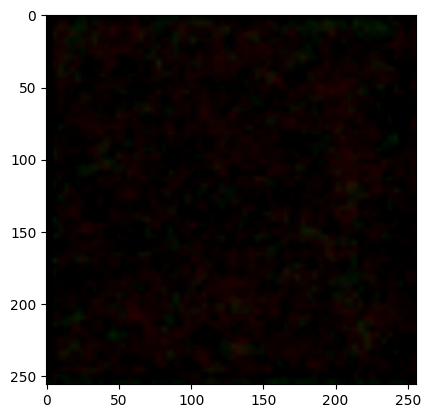

In [42]:
plt.imshow(k[0].detach().cpu().permute(1,2,0))

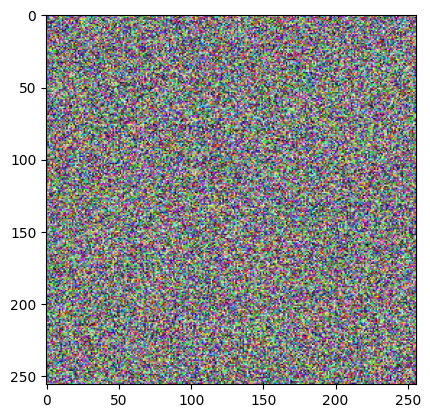

In [41]:
plt.imshow(imb[0].detach().cpu().permute(1,2,0))

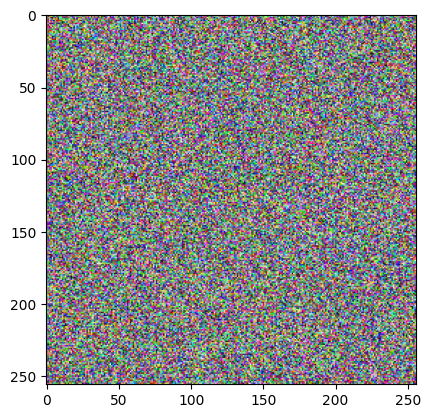

In [40]:
plt.imshow(ima[0].detach().cpu().permute(1,2,0))

In [23]:
u[:].unsqueeze(0).permute(1,0,2).shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
U = torch.rand(2,512).to('cuda')

In [ ]:
k[0].shape

torch.Size([2, 256, 64, 64])

In [ ]:
a = decode_head.forward(k,U,U)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x256 and 128x64)

In [ ]:
U.shape

torch.Size([2, 1, 512])

In [ ]:
a.shape

torch.Size([2, 3, 64, 64])

In [ ]:
clip_model, preprocess = clip.load('ViT-B/32',device=device)

In [ ]:
k,u = model.forward(ima,imb)

AttributeError: 'Model' object has no attribute 'size'

In [ ]:
type(k[0])
x_orig = [torch.cat([k[i], u[i]], dim=1) for i in range(len(k))]

# Data

In [10]:
fname = os.listdir('data/Levir-CC-dataset/images/train/A')[0]
fname

'train_003608.png'